## day-vs-night-Fig5copy

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    abs_diff = abs(b) - abs(a)
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'mean_abs_diff': np.nanmean( abs_diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

Set font sizes for plots

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Define the study area

In [4]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find all files and open

In [6]:
# original ABI images
original_filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')
ds_original = xr.open_mfdataset(original_filepaths, concat_dim='time', combine='nested')
ds_original = ds_original.rio.clip(geometry)

In [5]:
# orthorectified ABI images
ortho_filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
ds_ortho = xr.open_mfdataset(ortho_filepaths, concat_dim='time', combine='nested')
ds_ortho = ds_ortho.rio.clip(geometry)

### Make day vs night figure (like figure 5)

Histograms and 1-1 plots:

In [7]:
ds_ortho_day = ds_ortho.where(ds_ortho.time.dt.hour>12, drop=True)
ds_ortho_night = ds_ortho.where(ds_ortho.time.dt.hour<12, drop=True)

ds_original_day = ds_original.where(ds_original.time.dt.hour>12, drop=True)
ds_original_night = ds_original.where(ds_original.time.dt.hour<12, drop=True)

Daytime ast_mod_summary_stats: {'n': 122723, 'mean_diff': 0.23876462475159474, 'mean_abs_diff': 0.23876462475159474, 'median_diff': 0.10314022571799342, 'mean_squared_diff': 13.05472703358084, 'rms_diff': 3.613132579020709, 'std_diff': 3.6052348727299406, 'slope': 0.8022778296397324, 'intercept': 55.02603181551976, 'r_value': 0.771168587177768, 'p_value': 0.0, 'std_err': 0.0018906180030726233}
Nighttime ast_mod_summary_stats: {'n': 125000, 'mean_diff': -0.37302465289797554, 'mean_abs_diff': -0.37302465289797554, 'median_diff': -0.3334456131757122, 'mean_squared_diff': 3.30034580473626, 'rms_diff': 1.8166853895862816, 'std_diff': 1.7779759315206167, 'slope': 0.7184715652841769, 'intercept': 74.95837509091328, 'r_value': 0.7536991424590382, 'p_value': 0.0, 'std_err': 0.001772027830438004}
Daytime ast_goes_summary_stats {'n': 122723, 'mean_diff': 1.6219301813449822, 'mean_abs_diff': 1.6219301813449822, 'median_diff': 1.8982777381171445, 'mean_squared_diff': 5.025504702155022, 'rms_diff': 

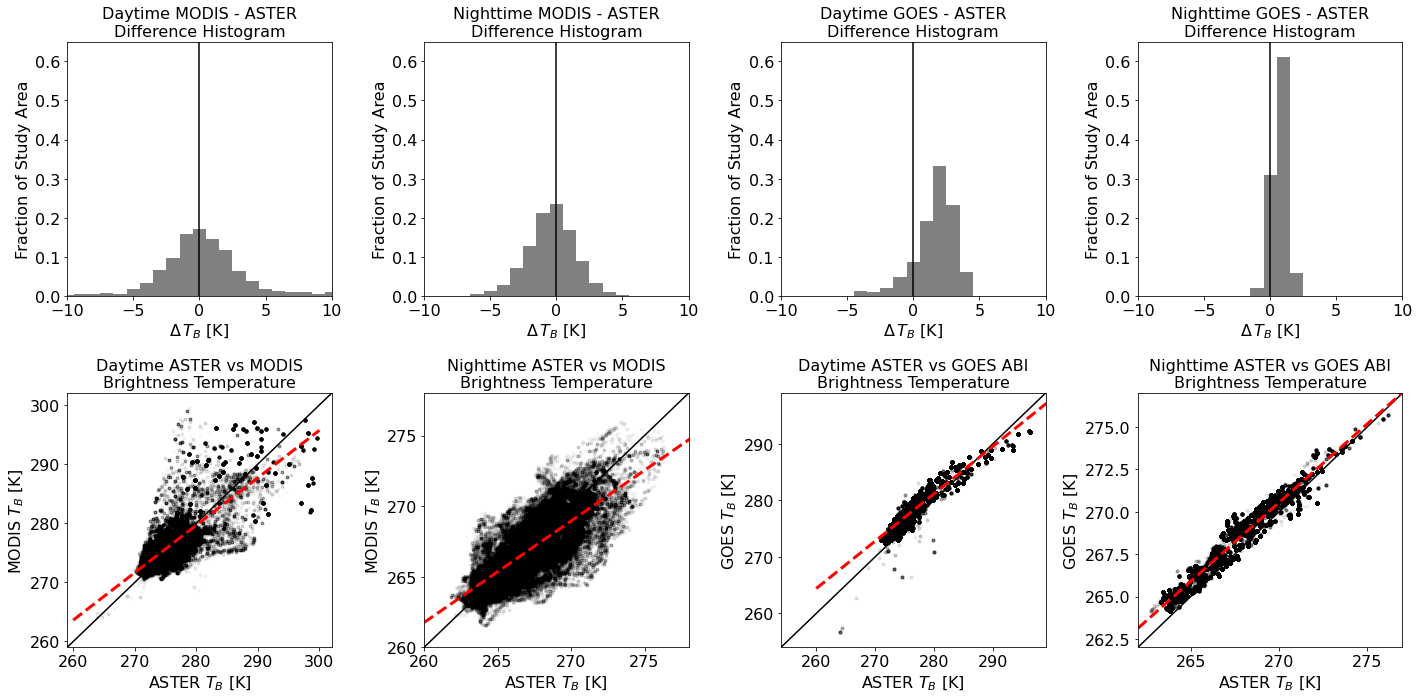

In [10]:
# datasets
_ds_original = ds_ortho_day.drop(time=ds_original.isel(time=25).time.values).mean(axis=0, skipna=True)
_ds_ortho = ds_ortho_night.mean(axis=0, skipna=True)

# make figure
fig = plt.figure(figsize=(20,10), tight_layout=True)
nrows = 2
ncols = 4

# make hist plot axes
ax_ast_mod_day_hist = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_ast_mod_night_hist = plt.subplot2grid((nrows, ncols), (0, 1), 1, 1)
ax_ast_goes_orig_hist = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
ax_ast_goes_ortho_hist = plt.subplot2grid((nrows, ncols), (0, 3), 1, 1)

# make 1-to-1 plots axes
ax_ast_mod_day_1to1 = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_mod_night_1to1 = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
ax_ast_goes_orig_1to1 = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
ax_ast_goes_ortho_1to1 = plt.subplot2grid((nrows, ncols), (1, 3), 1, 1)


lw=3 #line widths

### Plot the difference histograms ### 
mybins = np.arange(-10.5,11.5,1)
# Daytime MODIS-ASTER
_ds_original.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_day_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.std().values,1)))
#ax_ast_mod_day_hist.axvline(_ds_original.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.mean().values,1))) # mean line
ax_ast_mod_day_hist.set_title('Daytime MODIS - ASTER\nDifference Histogram')

# Daytime MODIS-ASTER
_ds_ortho.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_night_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.std().values,1)))
#ax_ast_mod_night_hist.axvline(_ds_ortho.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_mod_mean_diff_tb.mean().values,1))) # mean line
ax_ast_mod_night_hist.set_title('Nighttime MODIS - ASTER\nDifference Histogram')

# Daytime GOES-ASTER
_ds_original.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_orig_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_original.ast_goes_mean_diff_tb.std().values,1)))
#ax_ast_goes_orig_hist.axvline(_ds_original.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_orig_hist.set_title('Daytime GOES - ASTER\nDifference Histogram')

# Nighttime GOES-ASTER
_ds_ortho.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_ortho_hist, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(_ds_ortho.ast_goes_mean_diff_tb.std().values,1)))
#ax_ast_goes_ortho_hist.axvline(_ds_ortho.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_ortho.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_ortho_hist.set_title('Nighttime GOES - ASTER\nDifference Histogram')

### Format the axes limits on the histograms ###
for ax in [ax_ast_mod_day_hist,ax_ast_mod_night_hist, ax_ast_goes_orig_hist, ax_ast_goes_ortho_hist]:
    ax.set_xlim(-10,10)
    ax.set_ylim(0,0.65)
    ax.axvline(0, color='k', linestyle='-') # zero line
    #ax.legend(loc='upper left',facecolor='none',edgecolor='none')
    ax.set_xlabel('$\Delta\,T_B$ [K]')
    ax.set_ylabel('Fraction of Study Area')

### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ###

# Daytime ASTER and MODIS
ax_ast_mod_day_1to1.plot(_ds_original.ast_mod_mean_rad2tbK, _ds_original.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                      linestyle='none', marker='.', color='k', alpha=0.02)
ax_ast_mod_day_1to1.set_title('Daytime ASTER vs MODIS\nBrightness Temperature')
ax_ast_mod_day_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_mod_day_1to1.set_ylabel('MODIS $T_B$ [K]')

# Nighttime ASTER and MODIS
ax_ast_mod_night_1to1.plot(_ds_ortho.ast_mod_mean_rad2tbK, _ds_ortho.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                           linestyle='none', marker='.', color='k', alpha=0.02)
ax_ast_mod_night_1to1.set_title('Nighttime ASTER vs MODIS\nBrightness Temperature')
ax_ast_mod_night_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_mod_night_1to1.set_ylabel('MODIS $T_B$ [K]')

# Daytime ASTER and GOES
ax_ast_goes_orig_1to1.plot(_ds_original.ast_goes_mean_rad2tbK, _ds_original.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
ax_ast_goes_orig_1to1.set_title('Daytime ASTER vs GOES ABI\nBrightness Temperature')
ax_ast_goes_orig_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_orig_1to1.set_ylabel('GOES $T_B$ [K]')

# Nighttime ASTER and GOES
ax_ast_goes_ortho_1to1.plot(_ds_ortho.ast_goes_mean_rad2tbK, _ds_ortho.ast_goes_goes_tb, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.05)
ax_ast_goes_ortho_1to1.set_title('Nighttime ASTER vs GOES ABI\nBrightness Temperature')
ax_ast_goes_ortho_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_ortho_1to1.set_ylabel('GOES $T_B$ [K]')


### 1-to-1 plots and axes formatting ###
for ax_1_to_1 in [ax_ast_mod_day_1to1, ax_ast_mod_night_1to1, ax_ast_goes_orig_1to1, ax_ast_goes_ortho_1to1]:
    # get max and min values for axes
    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
    # add 1-to-1 line
    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
    # set axes limits
    ax_1_to_1.set_xlim((ax_min,ax_max))
    ax_1_to_1.set_ylim((ax_min,ax_max))

    
    
### add linear regressions to 1-to-1 plots: ###
x = np.array([260,300])
# Nighttime MODIS - ASTER
ast_mod_summary_stats = summary_stats(_ds_original.ast_mod_mean_rad2tbK.values.ravel(), _ds_original.ast_mod_modis_tb.values.ravel())
print('Daytime ast_mod_summary_stats:',ast_mod_summary_stats)
ax_ast_mod_day_1to1.plot(x, x*ast_mod_summary_stats['slope'] + ast_mod_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

# Nighttime MODIS - ASTER
ast_mod_summary_stats = summary_stats(_ds_ortho.ast_mod_mean_rad2tbK.values.ravel(), _ds_ortho.ast_mod_modis_tb.values.ravel())
print('Nighttime ast_mod_summary_stats:',ast_mod_summary_stats)
ax_ast_mod_night_1to1.plot(x, x*ast_mod_summary_stats['slope'] + ast_mod_summary_stats['intercept'],linestyle='--', lw=lw, color='r')


# Daytime GOES - ASTER
ast_goes_orig_summary_stats = summary_stats(_ds_original.ast_goes_mean_rad2tbK.values.ravel(), _ds_original.ast_goes_goes_tb.values.ravel())
print('Daytime ast_goes_summary_stats',ast_goes_orig_summary_stats)
ax_ast_goes_orig_1to1.plot(x, x*ast_goes_orig_summary_stats['slope'] + ast_goes_orig_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

# Nighttime GOES - ASTER
ast_goes_ortho_summary_stats = summary_stats(_ds_ortho.ast_goes_mean_rad2tbK.values.ravel(), _ds_ortho.ast_goes_goes_tb.values.ravel())
print('Nighttime ast_goes_summary_stats',ast_goes_ortho_summary_stats)
ax_ast_goes_ortho_1to1.plot(x, x*ast_goes_ortho_summary_stats['slope'] + ast_goes_ortho_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

plt.savefig('images/day-vs-night-ortho-Figure5.png',dpi=200)

---
---
---

In [ ]:
import scipy.stats as stats

Test the change in the mean differences before/after orthorectifying:

(null no change, alt decrease in mean)

Using a two-sided t test shows that this is a significant change in the mean. Notably though it's because we're essentially "oversampling" the GOES pixels... if we scale them (by dividing by 10000) we can make it no longer statistically significant.

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(_ds_original.ast_goes_mean_diff_tb, _ds_ortho.ast_goes_mean_diff_tb,
         linestyle='none', marker='.', color='k', alpha=0.02);
plt.xlabel('original')
plt.ylabel('ortho')
plt.xlim((-5,10))
plt.ylim((-5,10));

In [ ]:
# before
before = _ds_original.ast_goes_mean_diff_tb.values.ravel()
n = len(before) #/10000
print(n)

# after
after = _ds_ortho.ast_goes_mean_diff_tb.values.ravel()
m = len(after) #/10000
print(m)

# We want our alpha to be 0.05
alpha = 0.05
# This gives us a confidence of 0.95
conf = 1 - alpha

z_alpha = stats.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

# Compute the pooled standard deviaiton
pooled_sd = np.sqrt( np.nanstd(before,ddof=1)**2 / n + np.nanstd(after,ddof=1)**2 / m )

# hypothesizing no change
mu_0 = 0

# compute z-score
zscore = (np.nanmean(after) - np.nanmean(before) - mu_0)/pooled_sd

print("z-score = {}".format( np.round(zscore,2) )) 

pvalue = 1 - stats.norm.cdf(zscore)
print("p = {}".format( np.round(pvalue,3) ))

In [ ]:
# Create z values between -4 and 4 to look at the middle portion of the z-distribution around 0
# Scale our values by the pooled standard deviation (otherwise we'd be in generic z-distribution space)
z = np.linspace(-4, 4, num=160) * pooled_sd

# Create the plot
plt.figure(figsize=(5,4))
# Plot the z-distribution here
plt.plot(z, stats.norm.pdf(z, 0, pooled_sd), label='Null PDF: ($\overline{X}_2 - \overline{X}_1$) = 0')

# Plot a line at our z-alpha value and shade the rejection region
plt.axvline(-z_alpha*pooled_sd, color='black', linestyle='-', label='$z_{a}$')
shade = np.linspace(-z_alpha*pooled_sd, np.min(z), 10)
plt.fill_between(shade, stats.norm.pdf(shade, 0, pooled_sd) ,  color='k', alpha=0.5, label='rejection region\nfor alpha={}'.format(np.round(1-conf,2)))


plt.axvline(zscore*pooled_sd, color='red', linestyle='-', label='z-test')
plt.xlabel('($\overline{X}_2 - \overline{X}_1$)', fontsize=9)
plt.ylabel('PDF', fontsize=9)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#plt.ylim(0, 9e-5)
plt.legend(loc='best', fontsize=9);

Test the change in the standard deviation before/after orthorectifying:

(null no change, alt decrease in standard deviation) chi-square test

In [ ]:
# first calculate the test statistic
sd1 = np.nanstd(before) #we pretend this is the "true population standard deviation)
sd2 = np.nanstd(after)
m = len(after)
t = (m-1)*sd2**2/sd1**2
print(t)

In [ ]:
alpha = 0.05
critical_value = stats.chi2.ppf(alpha, m-1)
print(critical_value)